In [199]:
import osmnx as ox
import networkx as nx
import numpy as np

from matplotlib import pyplot as plt

In [200]:
graph = ox.load_graphml("../states_graph/graphml/gujarat_highways.graphml")
# graph = ox.convert.to_undirected(graph)

In [201]:
G = nx.DiGraph(graph)
source = list(G.nodes())[0]

In [202]:
connected_components = nx.number_weakly_connected_components(G)
print(connected_components)

1


In [203]:
start_node = source
max_depth = 200

layers = {}
visited = set()
queue = [(source, 0)]  # (node, layer)

while queue:
    node, layer = queue.pop(0)
    if node in visited:
        continue
    visited.add(node)

    # Add the node to its corresponding layer
    if layer not in layers:
        layers[layer] = []
    layers[layer].append(node)

    # Add neighbors to the queue for the next layer
    for neighbor in graph.neighbors(node):
        if neighbor not in visited:
            queue.append((neighbor, layer + 1))
            
for layer in layers.keys():
    print(f"{layer}: {layers[layer]}")

0: [349126490]
1: [9939289665]
2: [1519122647]
3: [6227305413]
4: [6030018628, 6227305411]
5: [1185821004, 6030018629]
6: [1519122650, 6030018792, 6030018677]
7: [11542200065, 11542200064, 5132776887, 9579857815, 452017426]
8: [9939289658, 1185790432, 5132776883, 9579857810, 452017371, 2211563011, 1207067950]
9: [1185820929, 4842689045, 4842689032, 2211572327, 2211562997]
10: [2314649604, 9697236833, 4535027507, 4842689035, 3897782667]
11: [2290795745, 3716995731, 2314649613, 9697236834, 349126632, 4838742841, 3897782683]
12: [2290795733, 2290795717, 9697236856, 1185821091, 2289976813, 4975712166, 3497352459, 2332288604, 2314649635]
13: [2290795728, 567879137, 9697236835, 9697236855, 567879296, 9697236836, 4842689026, 4975712167, 4975712163, 4975712172, 1997004307, 3497352445, 2338879641, 1996956127, 2338879768, 2338879758]
14: [2290795748, 2314610854, 9697236829, 9697236824, 11250841842, 4842689034, 4842689030, 349133190, 11921422522, 1997004251, 1997004218, 1848134369, 2338879714, 45

In [204]:
longest_walk = []  # To store the longest walk
n = 10000  # Number of times to run the random walk

for _ in range(n):
    # Reset the walk for each run
    walk = [start_node]
    current_layer = 0
    
    while current_layer < max_depth:
        current_node = walk[-1]
        next_layer = current_layer + 1

        # Get valid neighbors in the next layer
        valid_next_nodes = [
            node for node in layers.get(next_layer, []) 
            if node in G.neighbors(current_node) and node not in walk
        ]

        # If no valid next nodes, break
        if not valid_next_nodes:
            break

        # Randomly select next node
        next_node = np.random.choice(valid_next_nodes)
        walk.append(next_node)
        current_layer += 1

    # Update longest_walk if current walk is longer
    if len(walk) > len(longest_walk):
        longest_walk = walk

# Print the longest walk after running n times
print("Longest Walk:", longest_walk)
print("Length of Longest Walk:", len(longest_walk))


Longest Walk: [349126490, 9939289665, 1519122647, 6227305413, 6030018628, 6030018629, 6030018677, 452017426, 2211563011, 2211562997, 3897782667, 3897782683, 2314649635, 2338879758, 4846661825, 4846661827, 4846661824, 4846661826, 349132928, 4843296438, 2331545218, 2331545142, 2314671284, 4874059893, 4874059894, 2314671390, 1702578374, 2266310801, 5457217548, 11957811072, 11957811073, 11957811086, 5339048719]
Length of Longest Walk: 33


In [205]:
walk = longest_walk

In [206]:
for node in walk:
    if node not in G.nodes:
        print(f"Invalid node in path: {node}")

print(len(walk))
print(len(set(walk)))

33
33


In [207]:
from networkx.algorithms.components import is_connected, connected_components

sub_graph = graph.subgraph(walk)
sub_graph = ox.convert.to_undirected(sub_graph)
print(is_connected(sub_graph))

True


177917.46226474756


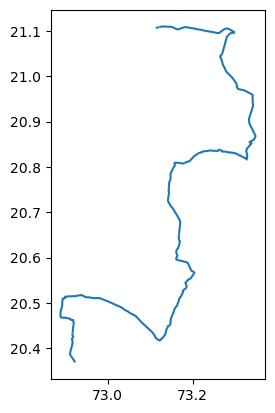

In [208]:
# fig,ax = ox.plot.plot_graph(sub_graph, edge_color='blue', node_color='red', node_size=50, edge_linewidth=3)
route = ox.routing.route_to_gdf(graph,walk)
route = route.to_crs(epsg=4326)
route.plot()
print(sum(route['length']))
# ox.plot_graph_route(sub_graph, walk, route_color='yellow')
plt.show()